In [1]:
import warnings 
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import gwpy
print(gwpy.__version__)

3.0.10


Handling data in the time domain

In [2]:
# Fetching data using GWOSC for the GW190412 detection of a gravitational wave signal
from gwosc.datasets import event_gps
gps = event_gps('GW190412')
print(gps)

1239082262.1


In [3]:
#building a 10 seconds segment arounf this time
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1239082257, 1239082267)


- G1 - GEO600
- H1 - LIGO-HANFORD
- L1 - LIGO-LIVINGSTON
- V1 - (Advanced) Virgo
- K1 - KAGRA

In [4]:
from gwpy.timeseries import TimeSeries
ldata = TimeSeries.fetch_open_data('L1',*segment,verbose=True)
print(ldata)

Fetched 1 URLs from gwosc.org for [1239082257 .. 1239082267))
Reading data... [Done]
TimeSeries([-8.42597565e-19, -8.52437103e-19, -8.60738804e-19,
            ...,  1.38850270e-19,  1.37760541e-19,
             1.38094202e-19]
           unit: dimensionless,
           t0: 1239082257.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


$\textbf{Notes:}$
- To control the dataset from which your data come from you can use the 'dataset' keyword. It is recommended to use data from a run if they are available, because they contain the most updated version of the calibration. To check which was the run at the time you want to query, it is enough to use the find_datasets method of the package gwosc discussed in the previous tutorial, specifying `type='run', segment=segment`. For example, for the segmemt we are using in this tutoial, the two available datasets are [`O3a_16KHZ_R1`, `O3a_4KHZ_R1`]. For sampling at 4kHz, the complete command to get data from this dataset is then: `TimeSeries.fetch_open_data('L1', *segment, verbose=True, dataset='O3a_4KHZ_R1')` as shown below.

- To read data from a local file instead of from the GWOSC server, we can use `TimeSeries.read` method.

In [5]:
from gwosc.datasets import find_datasets
print(find_datasets(type='run', segment=(int(gps)-5, int(gps)+5)))

['O3a_16KHZ_R1', 'O3a_4KHZ_R1']


In [6]:
# The following command is taking too long to run for some reason
#TimeSeries.fetch_open_data('L1', *segment, verbose=True, dataset='O3a_4KHZ_R1')

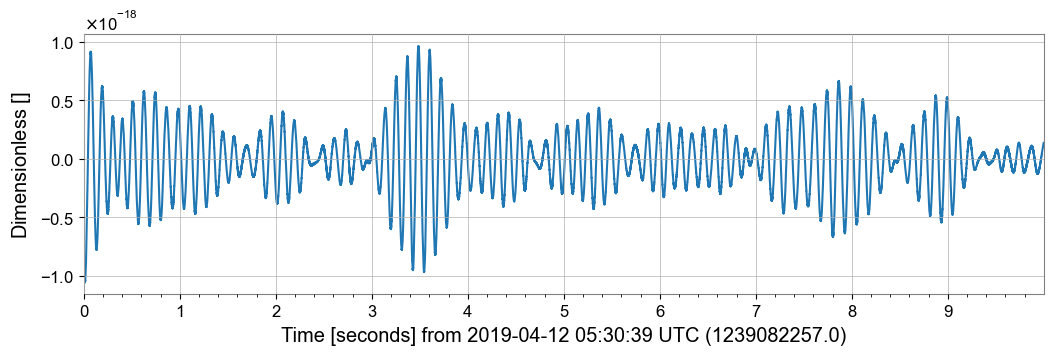

In [7]:
plot = ldata.plot()

Handling data in frequency domain using the FFT

In [8]:
fft = ldata.fft()  #This gives the Frequency series with complex amplitude, representing the amplitude and phase of the frequency in our data
# We can use the abs() method to get the amplitude.
print(fft)

FrequencySeries([-1.45894410e-21+0.00000000e+00j,
                 -2.91834926e-21-4.52905657e-23j,
                 -2.91973330e-21-9.06202944e-23j, ...,
                 -2.38723982e-23+4.67871178e-26j,
                 -2.38345362e-23+1.80394058e-26j,
                 -2.38457175e-23+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1239082257.0,
                name: Strain,
                channel: None)


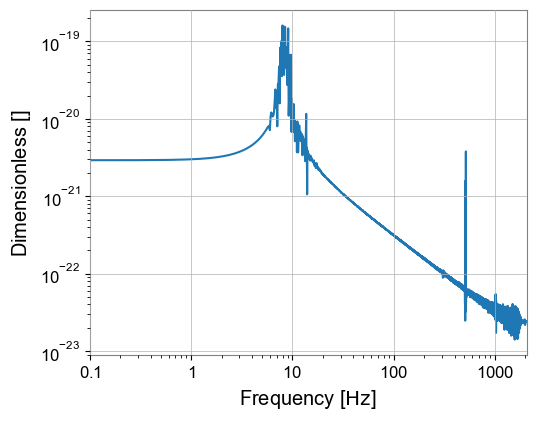

In [9]:
plot = fft.abs().plot(xscale='log', yscale='log')
# If the amplitude can be complex, then why do we need its magnitude and not just the real part?

This doesn't look correct at all! The problem is that the FFT works under the assumption that our data are periodic, which means that the edges of our data look like discontinuities when transformed. We need to apply a window function to our time-domain data before transforming, which we can do using the `scipy.signal` module:

In [10]:
from scipy.signal import get_window
window = get_window('hann', ldata.size)
lwin = ldata * window

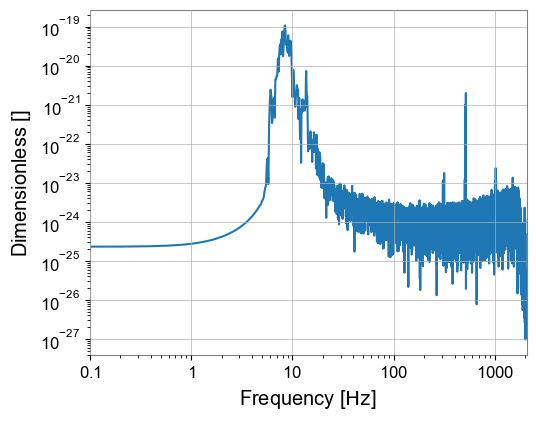

In [11]:
fftamp = lwin.fft().abs()
plot = fftamp.plot(xscale='log', yscale='log')
plot.show(warn=False)

Power Spectral Density

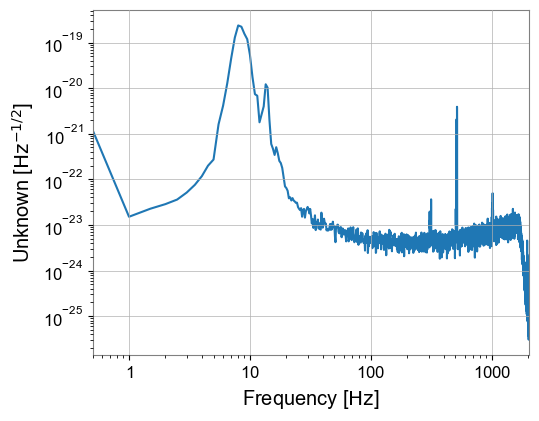

In [12]:
asd = ldata.asd(fftlength=2,method='median')  # here, asd stands for Amplitude Spectral Density
plot = asd.plot()
plot.show(warn=False)

In [13]:
sampling_rate = ldata.sample_rate.value
print(sampling_rate)
print(sampling_rate/2)

4096.0
2048.0


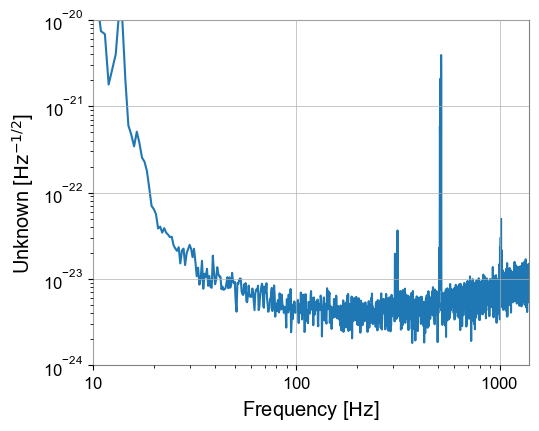

In [14]:
ax = plot.gca()
ax.set(xlim=(10, 1400), ylim=(1e-24,1e-20))  #Zooming in the (10, 1400) frequency range. Why 1400 Hz, I don't know??
plot

Visit https://gwosc.org/O3/o3aspeclines/ which describes a number of spectral features for O3.

Loading more data allows for more FFTs to be averaged during the ASD estimation (Welch estimation method), meaning random variations get averaged out, and we can see more details:

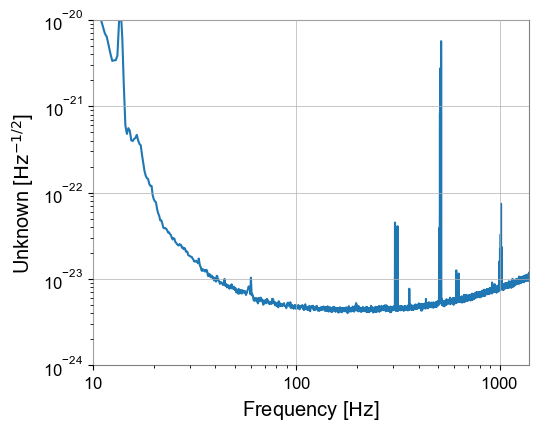

In [15]:
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method='median')
plot = lasd2.plot()
ax = plot.gca()
ax.set_xlim(10,1400)
ax.set_ylim(1e-24, 1e-20)
plot.show(warn=False)

Lets compare and plot the data from LIGO-Hanford and Virgo

In [16]:
#Get hanford data
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method='median')

In [17]:
#Get virgo data
vdata2 = TimeSeries.fetch_open_data('V1', int(gps)-512, int(gps)+512, cache=True)
vasd2 = vdata2.asd(fftlength=4, method='median')

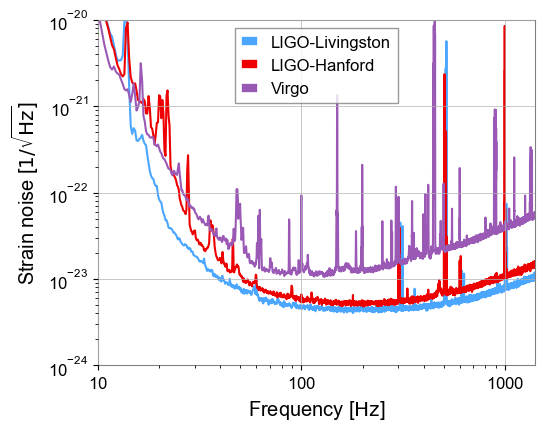

In [18]:
ax.plot(hasd2, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(vasd2, label='Virgo', color='gwpy:virgo')

lline = ax.lines[0]
lline.set_color('gwpy:ligo-livingston')
lline.set_label('LIGO-Livingston')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

# Challenges

1. Looking at the LIGO-Livingston data in the time domain, the peak amplitude of the gravitational-wave signal of GW190412 occurs at the center of the figure, that is, at approximately 5 seconds from the start of the segment. This peak is undetectable above the background noise by the eye. Plot the data for the LIGO-Hanford detector around GW190412. Looking at your new LIGO-Handford plot, can your eye identify a signal peak? What about Virgo data?

Fetched 1 URLs from gwosc.org for [1239082257 .. 1239082267))
Reading data... [Done]
TimeSeries([-4.95786471e-20, -4.54534103e-20, -3.15192804e-20,
            ...,  3.03308454e-19,  3.06989654e-19,
             3.06153067e-19]
           unit: dimensionless,
           t0: 1239082257.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


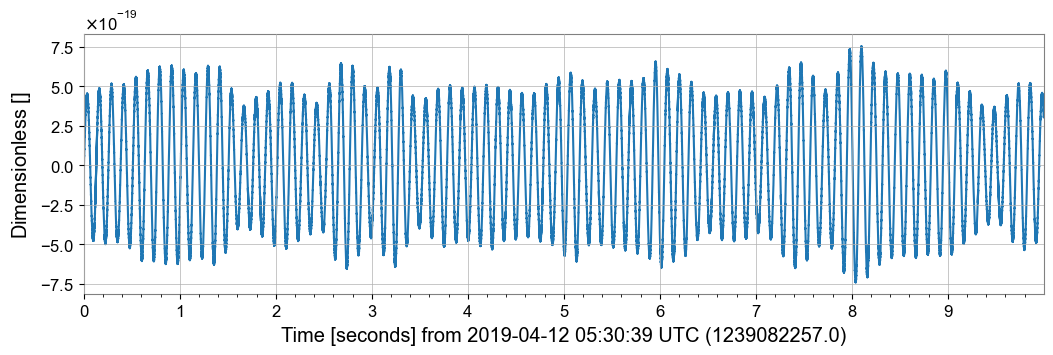

In [19]:
# Plotting the Handford data for the same time segment
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True)
print(hdata)
plot_h = hdata.plot()

Fetched 1 URLs from gwosc.org for [1239082257 .. 1239082267))
Reading data... [Done]
TimeSeries([-4.14628280e-20, -2.16068322e-20,  8.49382876e-21,
            ...,  1.97669207e-20, -7.11263366e-21,
            -2.44333694e-20]
           unit: dimensionless,
           t0: 1239082257.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


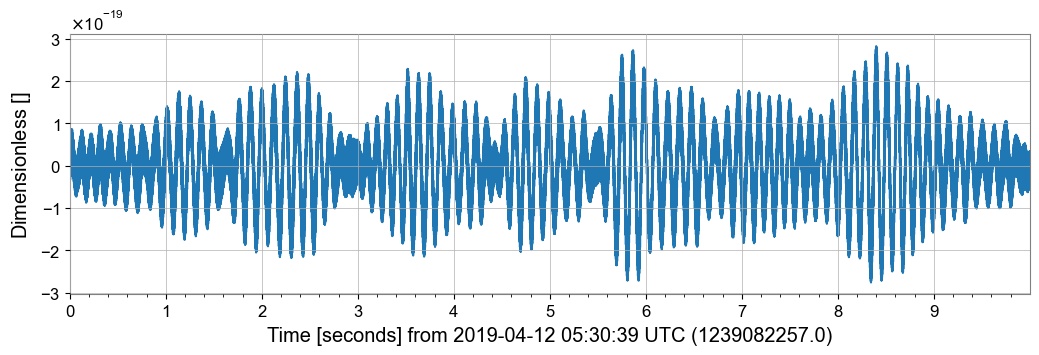

In [20]:
# Plotting the virgo data for the same time segment
vdata = TimeSeries.fetch_open_data('V1', *segment, verbose=True)
print(vdata)
plot_v = vdata.plot()   

2. Make an ASD around the time of an O1 event, GW150914 for L1 detector.  Compare this with the ASDs around GW190412 for L1 detector.  Which data have lower noise - and so are more sensitive - around 100 Hz?

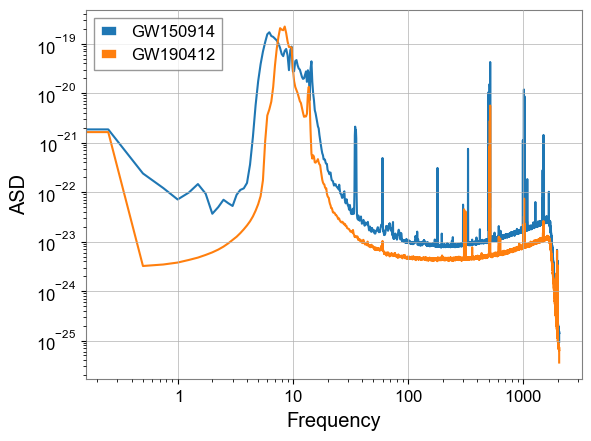

In [21]:
import matplotlib.pyplot as plt
from gwosc.datasets import event_gps

# For GW150914 (O1) event
gps_1 = event_gps('GW150914')
ldataq_1 = TimeSeries.fetch_open_data('L1', int(gps_1)-512, int(gps_1)+512, cache=True)
lasdq_1 = ldataq_1.asd(fftlength=4, method='median')

# For GW190412 event
gps_2 = event_gps('GW190412')
ldataq2 = TimeSeries.fetch_open_data('L1', int(gps_2)-512, int(gps_2)+512, cache=True)
lasdq2 = ldataq2.asd(fftlength=4, method='median')

plt.loglog(lasdq_1, label='GW150914')
plt.loglog(lasdq2, label='GW190412')
plt.xlabel('Frequency')
plt.ylabel('ASD')
plt.legend()